## HOMEWORK

### Dataset preparation

In [2]:
import os
import pandas as pd

DATA_DIR = "abo_data"  

METADATA_PATH = os.path.join(DATA_DIR, "images", "metadata", "images.csv")

print("Ścieżka:", METADATA_PATH, "=>", os.path.exists(METADATA_PATH))

df = pd.read_csv(METADATA_PATH)

print("Kolumny:", df.columns.tolist())

Ścieżka: abo_data/images/metadata/images.csv => True
Kolumny: ['image_id', 'height', 'width', 'path']


In [4]:
mask = (df["width"] >= 1000) & (df["height"] >= 1000)
df_big = df[mask]

image_paths = df_big["path"].tolist()

print("Number of big images:", len(image_paths))
print("Example Path:", image_paths[:5])

Number of big images: 342878
Example Path: ['46/4689906d.png', '0c/0cd7596c.jpg', 'e6/e602a9af.jpg', 'e7/e7cfeb02.jpg', '68/6839db4e.jpg']


### Model Selection and Understanding

Vector size  - clip-ViT-B-32: 512  

ViT = Vision Transformer  
B = Base - model variant  
32 = patch size 32×32 pixels  

## Database setup

In [9]:
from sqlalchemy.engine import URL
from sqlalchemy import create_engine

db_url = URL.create(
    drivername="postgresql+psycopg",
    username="postgres",
    password="password",
    host="localhost",
    port=5555,
    database="similarity_search_service_db", 
)

engine = create_engine(db_url)

In [17]:
from typing import List

from sqlalchemy.orm import DeclarativeBase, Mapped, mapped_column
from sqlalchemy import String
from pgvector.sqlalchemy import Vector

class Base(DeclarativeBase):
    __abstract__ = True

class Img(Base):
    __tablename__ = "images_clip" 
    __table_args__ = {'extend_existing': True}
    
    VECTOR_LENGTH: int = 512
    
    id: Mapped[int] = mapped_column(primary_key=True)
    image_path: Mapped[str] = mapped_column(String(512))
    embedding: Mapped[List[float]] =  mapped_column(Vector(VECTOR_LENGTH)) 
    
Base.metadata.create_all(engine)

## Image vectorization

In [13]:
import torch
from sentence_transformers import SentenceTransformer

print("CUDA available:", torch.cuda.is_available())

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model = SentenceTransformer("clip-ViT-B-32", device=device)

CUDA available: True
Using device: cuda


modules.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

0_CLIPModel/model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

0_CLIPModel/pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/604 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [18]:
import joblib
import torch
from PIL import Image
from sentence_transformers import SentenceTransformer
from tqdm.notebook import tqdm
from sqlalchemy.orm import Session
from itertools import islice   

MAX_IMAGES = 20_000         

BATCH_SIZE = joblib.cpu_count(only_physical_cores=True)

BASE_DIR = "abo_data/images/small"


def batched(iterable, n):
    it = iter(iterable)
    while True:
        batch = list(islice(it, n))
        if not batch:
            break
        yield batch   



def insert_images(engine, images):
    with Session(engine) as session:
        session.add_all(images)
        session.commit()

def vectorize_images(engine, model, image_paths):    
    with tqdm(total=MAX_IMAGES) as pbar:
        for images_paths_batch in batched(image_paths[:MAX_IMAGES], BATCH_SIZE):  
            images = [Image.open(os.path.join(BASE_DIR, path)).convert("RGB") for path in images_paths_batch]
        
            embeddings = model.encode(images, convert_to_numpy=True)

            imgs = [
                Img(
                    image_path=path,
                    embedding=emb.tolist()
                )
                for path, emb in zip(images_paths_batch, embeddings)
            ]
        
            insert_images(engine, imgs)
        
            pbar.update(len(imgs))

vectorize_images(engine, model, image_paths)

  0%|          | 0/20000 [00:00<?, ?it/s]

### Search and results display 

In [21]:
import matplotlib.pyplot as plt
from sqlalchemy import select

class ImageSearch:
    def __init__(self, engine, model):
        self.engine = engine
        self.model = model
        
    def __call__(self, image_description: str, k: int):
        found_images = self.find_similar_images(image_description, k)
        self.display_images(found_images)

        return found_images

    def find_similar_images(self, image_description: str, k: int):
        image_embedding = self.model.encode(image_description).tolist()
        
        query = (
            select(Img.image_path)
            .order_by(Img.embedding.cosine_distance(image_embedding))
            .limit(k)
        )

        with Session(self.engine) as session:
            result = session.scalars(query).all()

        return result
    
    def display_images(self, images):
        k = len(images)
        if k == 0:
            print("No results")
            return

        fig, axes = plt.subplots(1, k, figsize=(15, 5))
        
        for i, img_path in enumerate(images):
            full_path = os.path.join(BASE_DIR, img_path)
            img = Image.open(full_path)
            axes[i].imshow(img)
            axes[i].axis("off")
            axes[i].set_title(f"Image {i+1}")
        
        plt.show()

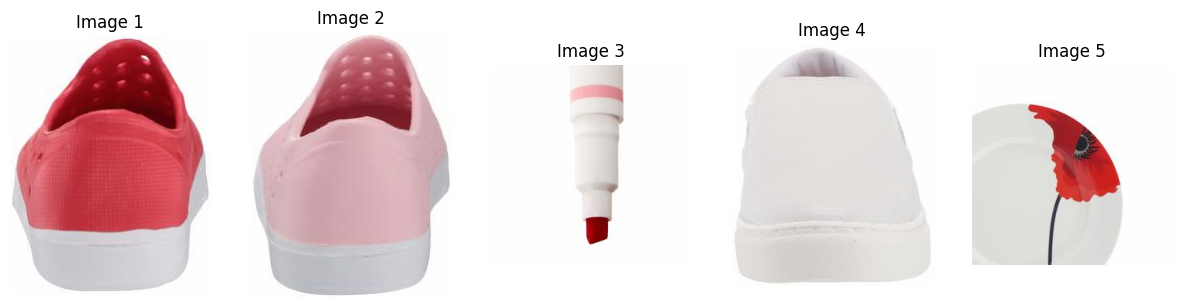

['9e/9e3747c7.jpg',
 'e8/e884b6b3.jpg',
 '60/60cd38c3.jpg',
 '71/7193f2df.jpg',
 '35/354c4653.jpg']

In [22]:
search = ImageSearch(engine, model)
search("a red shoe on white background", k=5)

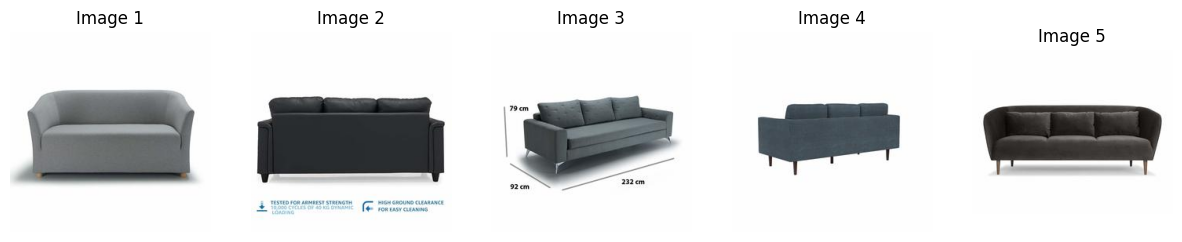

['e1/e1d65fd3.jpg',
 '7e/7ea161fa.jpg',
 'cd/cda8765b.jpg',
 '2e/2e6665dd.jpg',
 '09/0947e176.jpg']

In [23]:
search = ImageSearch(engine, model)
search("Dark gray L-shaped sofa on white background", k=5)